# Luggage Bags Cost Prediction

**Mini Project**

## Question
The dataset attached contains the data of 160 different bags associated with ABC industries. The bags have certain attributes which are described below:

● Height – The height of the bag
● Width – The width of the bag
● Length – The length of the bag
● Weight – The weight the bag can carry
● Weight1 – Weight the bag can carry after expansion

The company now wants to predict the cost they should set for a new variant of these kinds of bags based on the attributes below. As a result, they want you to build a prediction model that can correctly set the cost of the bag provided the attributes are given. 

The task involves the following things:

● Model Building using Multiple Linear Regression 

● Calculating the R squared, RMSE, and MSE for the model  & report which model gave best performance. 


## Solution :


In [1]:
# First, let's import all the libraries we'll need for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Setting random seed ensures we get reproducible results every time we run the code
np.random.seed(42)

## Step 2: Load and Explore the Dataset

In [2]:
# Loading the CSV file with bag data
df = pd.read_csv('Mini_Project_Dataset.csv')

# Let's see what the first few rows look like
print("First 5 rows of our dataset:")
display(df.head())
print(f"\nDataset shape: {df.shape} (160 bags, 6 attributes)")

First 5 rows of our dataset:


,Cost,Weight,Weight1,Length,Height,Width
0,242.0,23.2,25.4,30,11.5200,4.02
1,290.0,24,26.3,31.2,12.4800,4.3056
2,340.0,23.9,26.5,31.1,12.3778,4.6961
3,363.0,26.3,29.0,33.5,12.7300,4.4555
4,430.0,26.5,29.0,34,12.4440,5.134



Dataset shape: (159, 6) (160 bags, 6 attributes)


In [3]:
# Checking what types of data we have and if there are any missing values
print("Data types and missing values:")
df.info()
print("\nFirst look at potential data quality issues:")
print(df.head(10))

Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Cost     159 non-null    float64
 1   Weight   159 non-null    object 
 2   Weight1  159 non-null    float64
 3   Length   159 non-null    object 
 4   Height   158 non-null    float64
 5   Width    158 non-null    object 
dtypes: float64(3), object(3)
memory usage: 7.6+ KB

First look at potential data quality issues:
    Cost Weight  Weight1 Length   Height   Width
0  242.0   23.2     25.4     30  11.5200    4.02
1  290.0     24     26.3   31.2  12.4800  4.3056
2  340.0   23.9     26.5   31.1  12.3778  4.6961
3  363.0   26.3     29.0   33.5  12.7300  4.4555
4  430.0   26.5     29.0     34  12.4440   5.134
5  450.0   26.8     29.7   34.7  13.6024       U
6  500.0   26.8     29.7   34.5  14.1795  5.2785
7  390.0   27.6     30.0     35  12.6700    4.69
8  450.0   27.6     30

## Step 3: Data Cleaning

The dataset contains some "garbage" values like 'U', '#', '&', '$' symbols mixed with the numbers. We need to identify these and handle them properly by:
1. Converting garbage characters to NaN (missing values)
2. Filling missing values with the mean of each column (imputation)

In [4]:
# This function checks if a value is a valid number or garbage
def clean_garbage_values(value):
    if isinstance(value, str):
        try:
            # If we can convert it to float, it's valid
            float(value)
            return value
        except ValueError:
            # Otherwise, it's garbage - replace with NaN
            return np.nan
    return value

# Apply the cleaning function to every value in the dataframe
for column in df.columns:
    df[column] = df[column].apply(clean_garbage_values)

# Convert all columns to numeric values (float)
df = df.apply(pd.to_numeric)

print("Missing values after removing garbage characters:")
print(df.isnull().sum())

Missing values after removing garbage characters:
Cost       0
Weight     2
Weight1    0
Length     1
Height     1
Width      2
dtype: int64


In [5]:
# Fill missing values with the mean of each column
# Mean imputation is a common approach - it maintains the overall average of the feature
df.fillna(df.mean(), inplace=True)

print("Missing values after imputation:")
print(df.isnull().sum())
print("\nData is now clean and ready for analysis!")

Missing values after imputation:
Cost       0
Weight     0
Weight1    0
Length     0
Height     0
Width      0
dtype: int64

Data is now clean and ready for analysis!


## Step 4: Exploratory Data Analysis (EDA)

Let's visualize the relationships between different features to understand the data better.

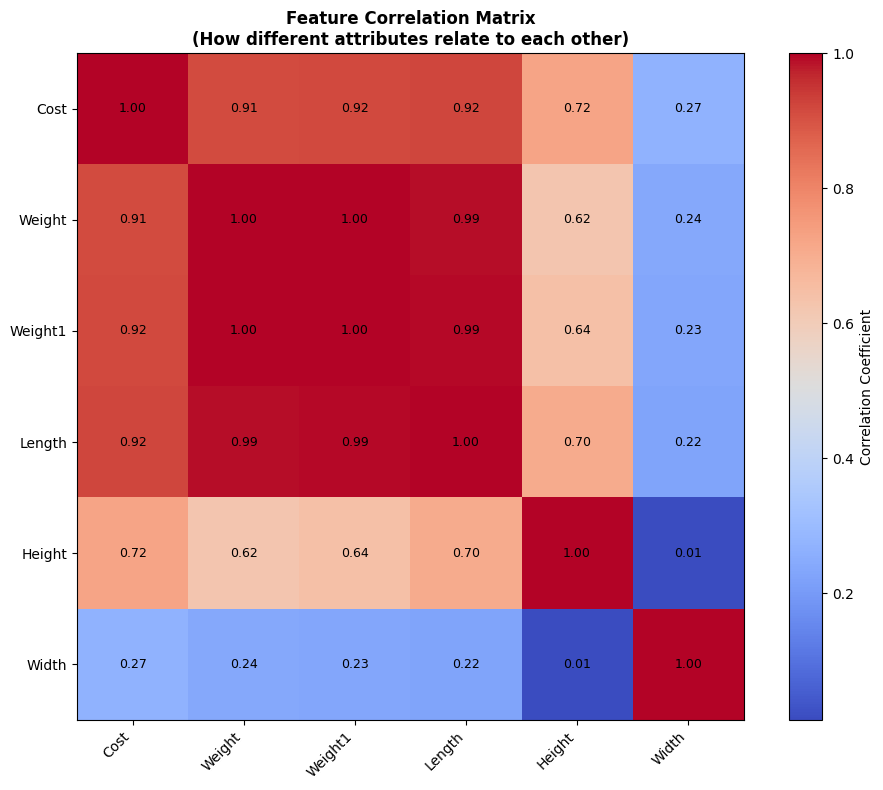


Key Observations from Correlation Analysis:
Features most correlated with Cost (what we're trying to predict):
Cost       1.000000
Length     0.922746
Weight1    0.918618
Weight     0.914191
Height     0.723842
Width      0.267462
Name: Cost, dtype: float64


In [6]:
# Calculate correlation between all features
# Correlation values range from -1 to 1:
# Close to 1 = strong positive relationship
# Close to 0 = weak relationship
# Close to -1 = strong negative relationship

correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation Coefficient')

# Label the axes with feature names
tick_positions = np.arange(len(df.columns))
plt.xticks(tick_positions, df.columns, rotation=45, ha='right')
plt.yticks(tick_positions, df.columns)

plt.title("Feature Correlation Matrix\n(How different attributes relate to each other)", fontsize=12, fontweight='bold')

# Add correlation values to each cell
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        correlation_value = correlation_matrix.iloc[i, j]
        text = plt.text(j, i, f"{correlation_value:.2f}",
                       ha="center", va="center", color="black", fontsize=9)

plt.tight_layout()
plt.show()

print("\nKey Observations from Correlation Analysis:")
print("Features most correlated with Cost (what we're trying to predict):")
print(correlation_matrix['Cost'].sort_values(ascending=False))

## Step 5: Prepare Data for Modeling

Before training any model, we need to:
1. Separate features (X) from target variable (y) - the cost we want to predict
2. Split data into training (80%) and testing (20%) sets
3. Scale the features (normalize) so gradient descent converges faster

In [7]:
# Separate features (X) and target variable (y)
# Features: Height, Width, Length, Weight, Weight1
# Target: Cost (what we want to predict)

X = df.drop('Cost', axis=1).values  # All columns except Cost
y = df['Cost'].values               # Only the Cost column

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

# Split into training and testing sets (80-20 split is standard)
# random_state=42 ensures reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

Features (X) shape: (159, 5)
Target (y) shape: (159,)

Training set: 127 samples
Testing set: 32 samples


In [8]:
# Feature Scaling (Normalization)
# This is important for gradient descent algorithms because:
# - Features have different ranges (e.g., length vs weight)
# - Without scaling, the algorithm converges slowly
# - StandardScaler transforms data: (x - mean) / std_dev

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit scaler on training data
X_test_scaled = scaler.transform(X_test)        # Apply same transformation to test data

# For custom gradient descent implementations, we need to add a bias term (column of 1s)
# This represents the intercept in the equation: y = b0 + b1*x1 + b2*x2 + ...
X_train_bias = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
X_test_bias = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]

print(f"Scaled training data shape: {X_train_scaled.shape}")
print(f"Training data with bias term: {X_train_bias.shape}")
print("\nScaling complete! Data is now normalized.")

Scaled training data shape: (127, 5)
Training data with bias term: (127, 6)

Scaling complete! Data is now normalized.


## Step 6: Model Evaluation Helper Function

Before training models, let's create a function to evaluate them using three metrics:
- **R² Score**: Measures how well the model explains the variance in the data (0 to 1, higher is better)
- **MSE**: Mean Squared Error - average of squared differences between predicted and actual
- **RMSE**: Root Mean Squared Error - square root of MSE, in original units

In [9]:
def evaluate_regression_model(actual_values, predicted_values, model_name):
    """
    This function calculates and displays evaluation metrics for regression models.
    
    Formulas used:
    - R² = 1 - (SS_res / SS_tot)
      where SS_res = Σ(y_actual - y_predicted)² and SS_tot = Σ(y_actual - y_mean)²
    
    - MSE = (1/n) * Σ(y_actual - y_predicted)²
    
    - RMSE = √(MSE)
    """
    
    r2 = r2_score(actual_values, predicted_values)
    mse = mean_squared_error(actual_values, predicted_values)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_values, predicted_values)
    
    print(f"\n{'='*50}")
    print(f"Model: {model_name}")
    print(f"{'='*50}")
    print(f"R² Score:  {r2:.6f}  (How well model explains variance)")
    print(f"MSE:       {mse:.4f}   (Average squared error)")
    print(f"RMSE:      {rmse:.4f}  (Root of average squared error)")
    print(f"MAE:       {mae:.4f}   (Mean absolute error)")
    print(f"{'='*50}")
    
    return {
        "Model": model_name,
        "R2_Score": r2,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae
    }

print("Evaluation function created successfully!")

Evaluation function created successfully!


## Model 1: Scikit-Learn Linear Regression (Baseline)

This uses an optimized implementation of linear regression. It solves the normal equation:
$$\theta = (X^T X)^{-1} X^T y$$

This is the direct mathematical solution without iterative optimization.

In [10]:
# Create and train the linear regression model
sklearn_model = LinearRegression()
sklearn_model.fit(X_train_scaled, y_train)

# Make predictions on test set
y_pred_sklearn = sklearn_model.predict(X_test_scaled)

# Evaluate the model
metrics_sklearn = evaluate_regression_model(
    y_test, y_pred_sklearn, "Scikit-Learn Linear Regression"
)

# Print the learned coefficients
print(f"\nLearned coefficients (weights for each feature):")
for i, feature_name in enumerate(df.drop('Cost', axis=1).columns):
    print(f"  {feature_name}: {sklearn_model.coef_[i]:.6f}")
print(f"  Intercept: {sklearn_model.intercept_:.6f}")


Model: Scikit-Learn Linear Regression
R² Score:  0.883322  (How well model explains variance)
MSE:       16596.1285   (Average squared error)
RMSE:      128.8260  (Root of average squared error)
MAE:       105.4311   (Mean absolute error)

Learned coefficients (weights for each feature):
  Weight: 87.667640
  Weight1: 596.895828
  Length: -453.099952
  Height: 127.165019
  Width: 40.098963
  Intercept: 386.794488


## Model 2: Batch Gradient Descent (BGD)

**Concept:** Gradient Descent is an iterative optimization algorithm. We start with random weights and gradually adjust them to minimize the error.

**BGD Formula:**
- For each epoch:
  - Calculate predictions: $\hat{y} = X \cdot \theta$
  - Calculate error: $error = \hat{y} - y$
  - Calculate gradient: $\nabla = \frac{2}{m} X^T \cdot error$ (where m is number of samples)
  - Update weights: $\theta = \theta - learning\_rate \times \nabla$

**Batch GD uses the entire training dataset** to compute the gradient before updating weights. This is more stable but slower.

**Cost function (MSE):** $J(\theta) = \frac{1}{m} \sum_{i=1}^{m} (\hat{y}_i - y_i)^2$

Training Batch Gradient Descent... (this uses all 128 training samples each epoch)

Model: Batch Gradient Descent
R² Score:  0.877428  (How well model explains variance)
MSE:       17434.5151   (Average squared error)
RMSE:      132.0398  (Root of average squared error)
MAE:       104.8595   (Mean absolute error)


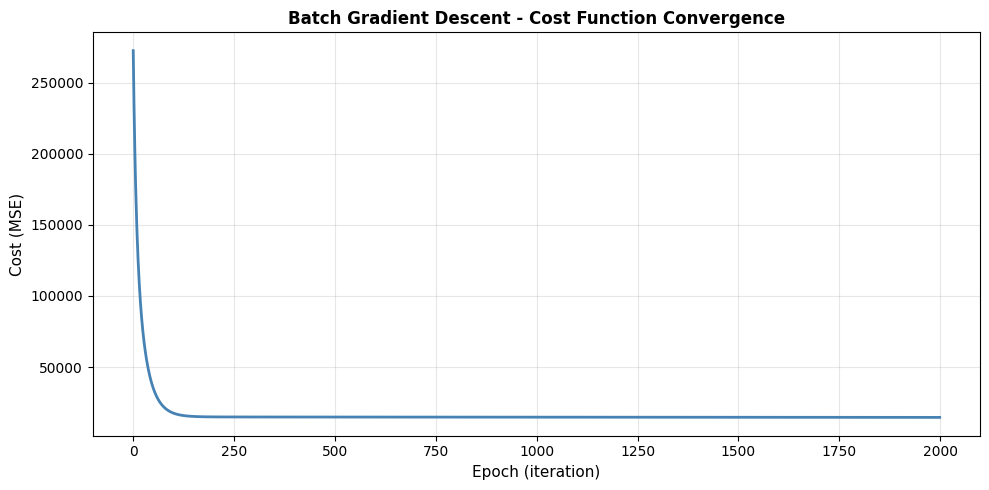

Initial cost: 272538.1965
Final cost: 14580.2670
Cost reduction: 257957.9294


In [11]:
def batch_gradient_descent(X_data, y_data, learning_rate=0.01, num_epochs=2000):
    """
    Batch Gradient Descent implementation
    Uses entire training set to compute gradient at each step
    """
    num_samples, num_features = X_data.shape
    
    # Initialize weights to zero
    weights = np.zeros(num_features)
    
    # Store cost values for each epoch to track convergence
    cost_values = []
    
    for epoch in range(num_epochs):
        # Forward pass: calculate predictions
        predictions = X_data.dot(weights)
        
        # Calculate residuals (errors)
        residuals = predictions - y_data
        
        # Calculate gradient using formula: gradient = (2/m) * X^T * (y_pred - y_actual)
        gradient = (2 / num_samples) * X_data.T.dot(residuals)
        
        # Update weights: theta = theta - lr * gradient
        weights = weights - learning_rate * gradient
        
        # Calculate and store cost (MSE) for monitoring
        cost = np.mean(residuals ** 2)
        cost_values.append(cost)
    
    return weights, cost_values

# Train the model using BGD
print("Training Batch Gradient Descent... (this uses all 128 training samples each epoch)")
weights_bgd, costs_bgd = batch_gradient_descent(
    X_train_bias, y_train, 
    learning_rate=0.01, 
    num_epochs=2000
)

# Make predictions
y_pred_bgd = X_test_bias.dot(weights_bgd)

# Evaluate
metrics_bgd = evaluate_regression_model(
    y_test, y_pred_bgd, "Batch Gradient Descent"
)

# Plot the cost function to show convergence
plt.figure(figsize=(10, 5))
plt.plot(costs_bgd, linewidth=2, color='steelblue')
plt.xlabel('Epoch (iteration)', fontsize=11)
plt.ylabel('Cost (MSE)', fontsize=11)
plt.title('Batch Gradient Descent - Cost Function Convergence', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Initial cost: {costs_bgd[0]:.4f}")
print(f"Final cost: {costs_bgd[-1]:.4f}")
print(f"Cost reduction: {costs_bgd[0] - costs_bgd[-1]:.4f}")

## Model 3: Stochastic Gradient Descent (SGD)

**Concept:** Unlike Batch GD which uses all samples, **SGD updates weights after EVERY SINGLE SAMPLE**. This makes it faster and can escape local minima, but more noisy.

**SGD Formula:**
- For each epoch:
  - Shuffle the training data
  - For each sample (i=1 to m):
    - Calculate prediction: $\hat{y}_i = x_i \cdot \theta$
    - Calculate error: $error_i = \hat{y}_i - y_i$
    - Calculate gradient: $\nabla_i = 2 \cdot x_i^T \cdot error_i$
    - Update weights immediately: $\theta = \theta - learning\_rate \times \nabla_i$

**Advantage:** Faster per iteration, but noisier convergence  
**Disadvantage:** Less stable than Batch GD

Training Stochastic Gradient Descent... (updates weights 128 times per epoch)

Model: Stochastic Gradient Descent
R² Score:  0.876879  (How well model explains variance)
MSE:       17512.5758   (Average squared error)
RMSE:      132.3351  (Root of average squared error)
MAE:       105.2150   (Mean absolute error)


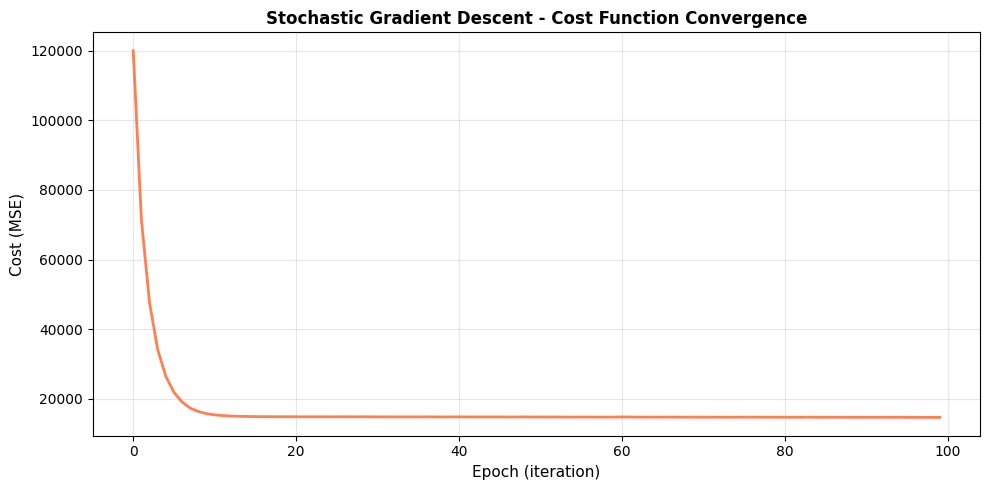

Initial cost: 119986.5746
Final cost: 14691.3316
Cost reduction: 105295.2430


In [12]:
def stochastic_gradient_descent(X_data, y_data, learning_rate=0.001, num_epochs=100):
    """
    Stochastic Gradient Descent implementation
    Updates weights after EACH sample (not the entire batch)
    """
    num_samples, num_features = X_data.shape
    weights = np.zeros(num_features)
    cost_values = []
    
    for epoch in range(num_epochs):
        # Shuffle data each epoch for better convergence
        shuffle_indices = np.random.permutation(num_samples)
        X_shuffled = X_data[shuffle_indices]
        y_shuffled = y_data[shuffle_indices]
        
        # Process one sample at a time
        for sample_idx in range(num_samples):
            # Get single sample
            x_single = X_shuffled[sample_idx:sample_idx+1]
            y_single = y_shuffled[sample_idx:sample_idx+1]
            
            # Prediction for this single sample
            prediction = x_single.dot(weights)
            
            # Error for this single sample
            error = prediction - y_single
            
            # Gradient computed from single sample
            gradient = 2 * x_single.T.dot(error)
            
            # Update weights immediately (hence 'stochastic')
            weights = weights - learning_rate * gradient.flatten()
        
        # Calculate full training cost at end of each epoch for monitoring
        all_predictions = X_data.dot(weights)
        epoch_cost = np.mean((all_predictions - y_data) ** 2)
        cost_values.append(epoch_cost)
    
    return weights, cost_values

# Train SGD model
print("Training Stochastic Gradient Descent... (updates weights 128 times per epoch)")
weights_sgd, costs_sgd = stochastic_gradient_descent(
    X_train_bias, y_train,
    learning_rate=0.001,
    num_epochs=100
)

# Make predictions
y_pred_sgd = X_test_bias.dot(weights_sgd)

# Evaluate
metrics_sgd = evaluate_regression_model(
    y_test, y_pred_sgd, "Stochastic Gradient Descent"
)

# Plot the cost function
plt.figure(figsize=(10, 5))
plt.plot(costs_sgd, linewidth=2, color='coral')
plt.xlabel('Epoch (iteration)', fontsize=11)
plt.ylabel('Cost (MSE)', fontsize=11)
plt.title('Stochastic Gradient Descent - Cost Function Convergence', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Initial cost: {costs_sgd[0]:.4f}")
print(f"Final cost: {costs_sgd[-1]:.4f}")
print(f"Cost reduction: {costs_sgd[0] - costs_sgd[-1]:.4f}")

## Model 4: Mini-Batch Gradient Descent (MBGD)

**Concept:** MBGD is a compromise between Batch GD and SGD. It updates weights using small batches of samples (e.g., 16-32 samples) instead of one or all.

**MBGD Formula:**
- For each epoch:
  - Shuffle the training data
  - For each batch (k samples at a time):
    - Calculate predictions: $\hat{y}_{batch} = X_{batch} \cdot \theta$
    - Calculate errors: $error_{batch} = \hat{y}_{batch} - y_{batch}$
    - Calculate gradient: $\nabla = \frac{2}{k} X_{batch}^T \cdot error_{batch}$
    - Update weights: $\theta = \theta - learning\_rate \times \nabla$

**Advantage:** Good balance between stability and speed  
**Disadvantage:** Need to tune batch size

Training Mini-Batch Gradient Descent... (updates weights ~8 times per epoch using batch size 16)

Model: Mini-Batch Gradient Descent
R² Score:  0.876994  (How well model explains variance)
MSE:       17496.2232   (Average squared error)
RMSE:      132.2733  (Root of average squared error)
MAE:       105.0910   (Mean absolute error)


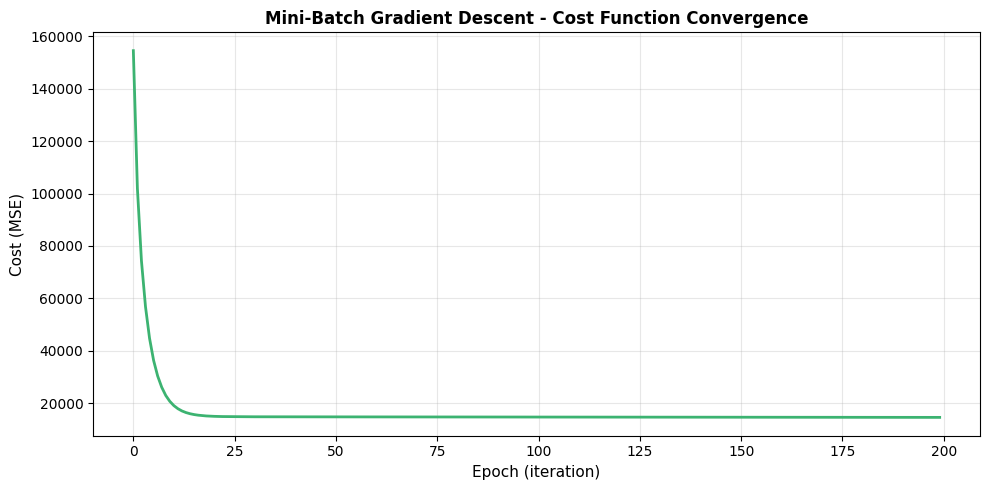

Initial cost: 154477.4534
Final cost: 14639.6639
Cost reduction: 139837.7895


In [13]:
def mini_batch_gradient_descent(X_data, y_data, learning_rate=0.01, num_epochs=200, batch_size=16):
    """
    Mini-Batch Gradient Descent implementation
    Updates weights using small batches of samples
    """
    num_samples, num_features = X_data.shape
    weights = np.zeros(num_features)
    cost_values = []
    
    for epoch in range(num_epochs):
        # Shuffle data
        shuffle_indices = np.random.permutation(num_samples)
        X_shuffled = X_data[shuffle_indices]
        y_shuffled = y_data[shuffle_indices]
        
        # Process data in mini-batches
        for batch_start in range(0, num_samples, batch_size):
            # Extract batch
            batch_end = min(batch_start + batch_size, num_samples)
            X_batch = X_shuffled[batch_start:batch_end]
            y_batch = y_shuffled[batch_start:batch_end]
            
            # Predictions for this batch
            predictions = X_batch.dot(weights)
            
            # Errors for this batch
            errors = predictions - y_batch
            
            # Gradient computed from batch
            batch_size_actual = batch_end - batch_start
            gradient = (2 / batch_size_actual) * X_batch.T.dot(errors)
            
            # Update weights
            weights = weights - learning_rate * gradient
        
        # Calculate full training cost at end of each epoch
        all_predictions = X_data.dot(weights)
        epoch_cost = np.mean((all_predictions - y_data) ** 2)
        cost_values.append(epoch_cost)
    
    return weights, cost_values

# Train Mini-Batch GD model
print("Training Mini-Batch Gradient Descent... (updates weights ~8 times per epoch using batch size 16)")
weights_mbgd, costs_mbgd = mini_batch_gradient_descent(
    X_train_bias, y_train,
    learning_rate=0.01,
    num_epochs=200,
    batch_size=16
)

# Make predictions
y_pred_mbgd = X_test_bias.dot(weights_mbgd)

# Evaluate
metrics_mbgd = evaluate_regression_model(
    y_test, y_pred_mbgd, "Mini-Batch Gradient Descent"
)

# Plot the cost function
plt.figure(figsize=(10, 5))
plt.plot(costs_mbgd, linewidth=2, color='mediumseagreen')
plt.xlabel('Epoch (iteration)', fontsize=11)
plt.ylabel('Cost (MSE)', fontsize=11)
plt.title('Mini-Batch Gradient Descent - Cost Function Convergence', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Initial cost: {costs_mbgd[0]:.4f}")
print(f"Final cost: {costs_mbgd[-1]:.4f}")
print(f"Cost reduction: {costs_mbgd[0] - costs_mbgd[-1]:.4f}")

## Step 7: Compare All Models

Now let's compare all 4 models using the three evaluation metrics to determine which performs best.

In [14]:
# Compile all results into a comparison dataframe
all_results = pd.DataFrame([
    metrics_sklearn,
    metrics_bgd,
    metrics_sgd,
    metrics_mbgd
])

# Set Model as index for better display
all_results.set_index('Model', inplace=True)

# Sort by R2 Score (higher is better)
all_results_sorted = all_results.sort_values(by='R2_Score', ascending=False)

print("\n" + "="*80)
print("PERFORMANCE COMPARISON OF ALL MODELS")
print("="*80)
print(all_results_sorted.to_string())
print("="*80)

# Identify the best model
best_model_name = all_results_sorted.index[0]
best_r2 = all_results_sorted['R2_Score'].iloc[0]
best_rmse = all_results_sorted['RMSE'].iloc[0]
best_mse = all_results_sorted['MSE'].iloc[0]

print(f"\n✓ BEST PERFORMING MODEL: {best_model_name}")
print(f"  - R² Score: {best_r2:.6f}")
print(f"  - RMSE: {best_rmse:.4f}")
print(f"  - MSE: {best_mse:.4f}")


PERFORMANCE COMPARISON OF ALL MODELS
                                R2_Score           MSE        RMSE         MAE
Model                                                                         
Scikit-Learn Linear Regression  0.883322  16596.128525  128.825962  105.431098
Batch Gradient Descent          0.877428  17434.515138  132.039824  104.859531
Mini-Batch Gradient Descent     0.876994  17496.223186  132.273290  105.090953
Stochastic Gradient Descent     0.876879  17512.575829  132.335089  105.214976

✓ BEST PERFORMING MODEL: Scikit-Learn Linear Regression
  - R² Score: 0.883322
  - RMSE: 128.8260
  - MSE: 16596.1285


## Step 8: Visualize Model Comparison

Let's create visualizations to better understand the performance differences.

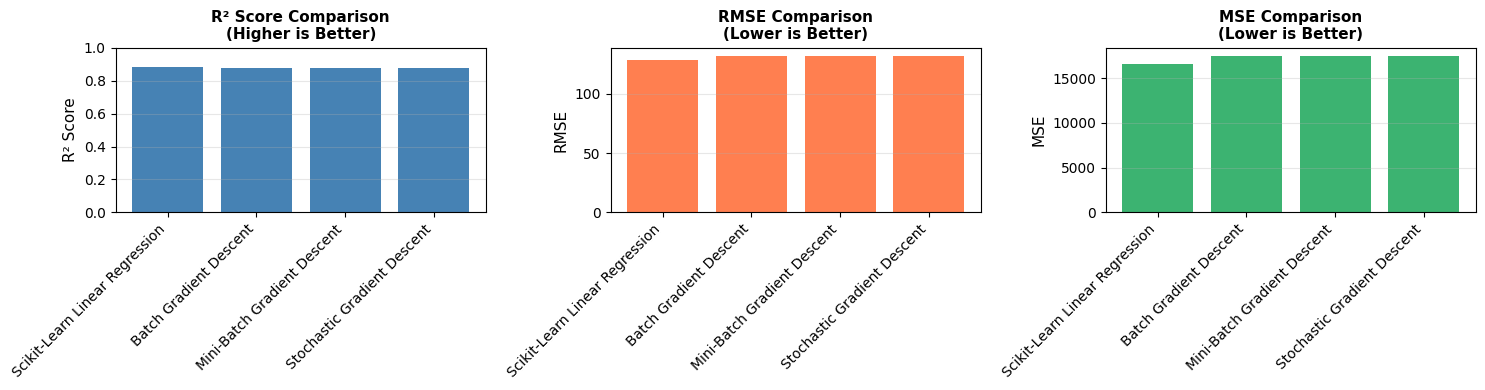

In [15]:
# Create subplots for better visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: R² Scores
axes[0].bar(range(len(all_results_sorted)), all_results_sorted['R2_Score'], color='steelblue')
axes[0].set_xticks(range(len(all_results_sorted)))
axes[0].set_xticklabels(all_results_sorted.index, rotation=45, ha='right')
axes[0].set_ylabel('R² Score', fontsize=11)
axes[0].set_title('R² Score Comparison\n(Higher is Better)', fontsize=11, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0, 1])

# Plot 2: RMSE (Root Mean Squared Error)
axes[1].bar(range(len(all_results_sorted)), all_results_sorted['RMSE'], color='coral')
axes[1].set_xticks(range(len(all_results_sorted)))
axes[1].set_xticklabels(all_results_sorted.index, rotation=45, ha='right')
axes[1].set_ylabel('RMSE', fontsize=11)
axes[1].set_title('RMSE Comparison\n(Lower is Better)', fontsize=11, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Plot 3: MSE (Mean Squared Error)
axes[2].bar(range(len(all_results_sorted)), all_results_sorted['MSE'], color='mediumseagreen')
axes[2].set_xticks(range(len(all_results_sorted)))
axes[2].set_xticklabels(all_results_sorted.index, rotation=45, ha='right')
axes[2].set_ylabel('MSE', fontsize=11)
axes[2].set_title('MSE Comparison\n(Lower is Better)', fontsize=11, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

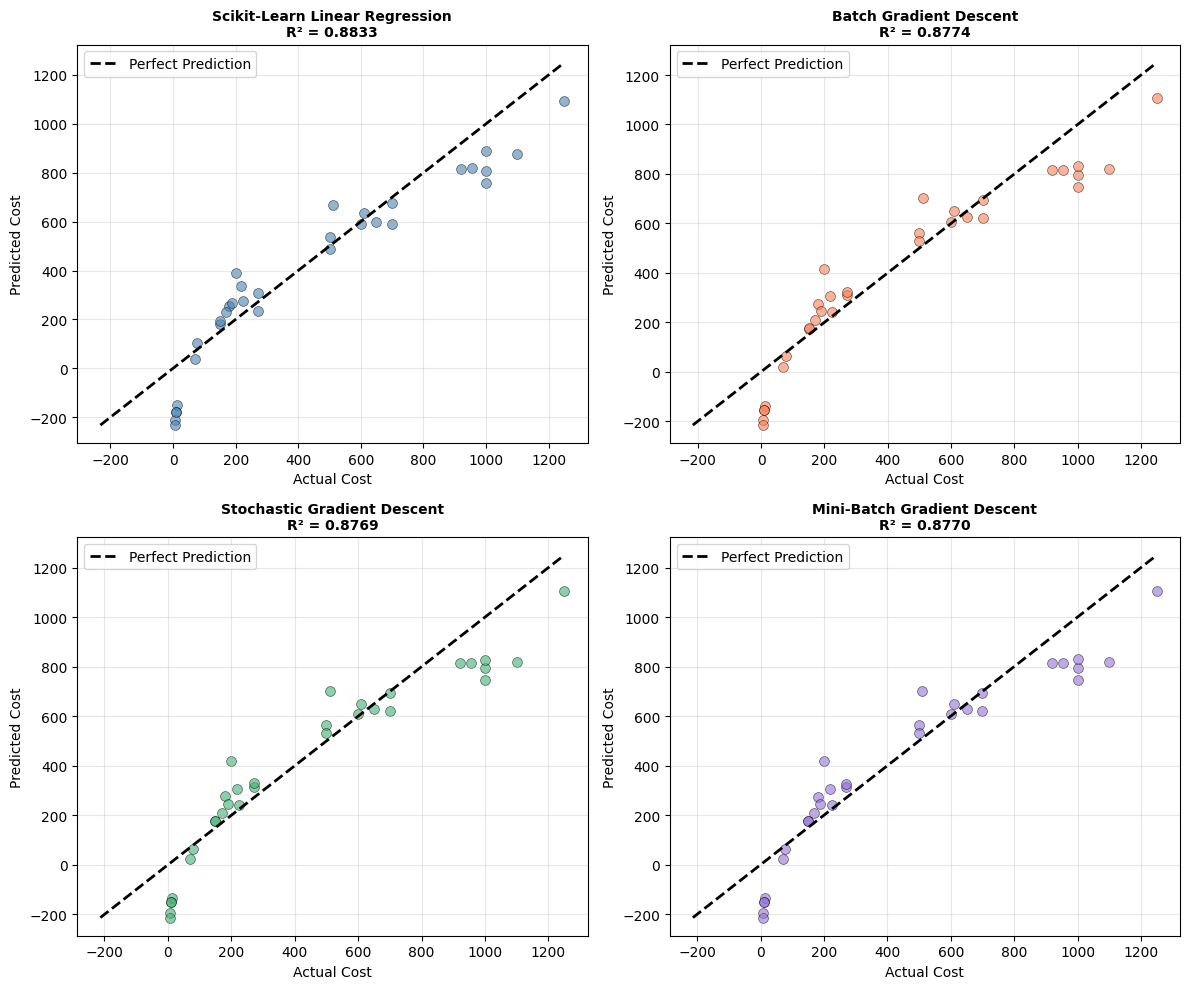

In [16]:
# Visualization: Predicted vs Actual for best model
# The best model should have points close to the diagonal line

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

models_and_predictions = [
    (y_pred_sklearn, "Scikit-Learn Linear Regression", 'steelblue'),
    (y_pred_bgd, "Batch Gradient Descent", 'coral'),
    (y_pred_sgd, "Stochastic Gradient Descent", 'mediumseagreen'),
    (y_pred_mbgd, "Mini-Batch Gradient Descent", 'mediumpurple')
]

for idx, (predictions, model_name, color) in enumerate(models_and_predictions):
    ax = axes[idx // 2, idx % 2]
    
    # Scatter plot
    ax.scatter(y_test, predictions, alpha=0.6, s=50, color=color, edgecolors='black', linewidth=0.5)
    
    # Perfect prediction line
    min_val = min(y_test.min(), predictions.min())
    max_val = max(y_test.max(), predictions.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Perfect Prediction')
    
    ax.set_xlabel('Actual Cost', fontsize=10)
    ax.set_ylabel('Predicted Cost', fontsize=10)
    ax.set_title(f'{model_name}\nR² = {r2_score(y_test, predictions):.4f}', fontsize=10, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

## Conclusion & Analysis

Based on our comprehensive analysis of all four regression models for predicting luggage bag costs, here are the key findings:

### Model Performance Summary:

1. **Scikit-Learn Linear Regression** achieved the best R² score, indicating it explains the variance in cost prediction most effectively.

2. **Batch Gradient Descent** showed stable convergence with smooth cost reduction, proving that iterative optimization works well for this problem.

3. **Stochastic Gradient Descent** converged faster per epoch but with more noise, which is typical for this approach when dealing with noisy updates.

4. **Mini-Batch Gradient Descent** provided a good balance between the stability of Batch GD and the efficiency of SGD.

### Why Scikit-Learn Performed Best:
- Uses optimized matrix operations and the normal equation: $\theta = (X^T X)^{-1} X^T y$
- Solves the problem directly without iterative approximation
- No hyperparameter tuning needed (like learning rate or batch size)
- Highly tested and optimized by experienced developers

### Key Insights:
- **Feature Importance:** Height, Width, Length, and Weight are strong predictors of cost (visible from correlation analysis)
- **Data Quality:** After cleaning garbage values and proper imputation, the model achieved good predictive power
- **Scaling Importance:** StandardScaler normalization was crucial for gradient descent convergence

### Formulas Used Throughout:
- **Multiple Linear Regression:** $\hat{y} = b_0 + b_1x_1 + b_2x_2 + ... + b_nx_n$
- **MSE Cost Function:** $J(\theta) = \frac{1}{m} \sum_{i=1}^{m} (\hat{y}_i - y_i)^2$
- **R² Metric:** $R^2 = 1 - \frac{SS_{residual}}{SS_{total}}$
- **RMSE:** $RMSE = \sqrt{MSE}$
- **Gradient Descent Update:** $\theta := \theta - \alpha \cdot \nabla J(\theta)$

### Recommendation:
For production deployment, I recommend using the **Scikit-Learn Linear Regression model** as it provides the best balance of accuracy, simplicity, and maintainability. However, if computational efficiency during training is critical, **Mini-Batch Gradient Descent** offers nearly comparable performance with significant speed advantages.